# Import modules

In [1]:
import os.path
import pickle
from typing import Any

from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from keras.models import load_model

# Bert Embeddings

In [2]:
models_path = os.path.join("..", "models", "bert_embeddings")
data_path = os.path.join("..", "data", "bert_embeddings")

In [3]:
def load_pickle(path: str) -> Any:
    """
    Loading pickle
    :param path: Path to file
    :return: Loaded object
    """
    with open(path, "rb") as f:
        return pickle.load(f)


test_data = load_pickle(os.path.join(data_path, "test.pkl"))
test_data

,screen_name,text,account.type,class_type,bert_embeddings
0,human#17,justin timberlake really one of the goats if y...,human,human,"[0.40757266, -0.10863766, -0.2410942, -0.06365..."
1,human#11,Thank you <MENTION> for your gracious prayers ...,human,human,"[-0.07554037, 0.14875665, -0.08754658, 0.33505..."
2,human#1,Theory : the number of red lights you will hit...,human,human,"[0.3313343, -0.07719195, -0.0047796066, -0.117..."
3,bot#12,Respects on the Upt of the I good with the peo...,bot,rnn,"[0.05469208, -0.05989903, 0.04778375, 0.127498..."
4,human#10,Might give the BASIC #10Liner game contest ano...,human,human,"[0.27779624, 0.10851603, -0.05910875, 0.278205..."
...,...,...,...,...,...
2553,bot#1,“ The best kept secret,bot,others,"[0.23446886, 0.31304237, -0.45918703, -0.03109..."
2554,human#10,Love the Choose your own adventure style of th...,human,human,"[0.23738243, 0.090966, 0.046297967, 0.15562175..."
2555,bot#4,JOIN OUR TEAM : Sneezing,bot,gpt2,"[-0.10720911, -0.068221435, 0.01753603, 0.4808..."
2556,human#10,These deeply discounted 256GB SanDisk flash dr...,human,human,"[0.09007341, 0.08707813, 0.17442508, 0.1354407..."


In [4]:
x = np.concatenate([x.reshape(1, -1) for x in test_data["bert_embeddings"]])
y = np.where(test_data["account.type"] == "bot", 1, 0)
x.shape, y.shape

((2558, 768), (2558,))

In [5]:
def get_results_bert(models_path, x, y, test_data) -> pd.DataFrame:
    results = []
    bots_types = test_data["class_type"]
    for model_path in os.listdir(models_path):
        model = load_pickle(os.path.join(models_path, model_path))
        for bot_type in bots_types.unique():
            proper_index = test_data[test_data["class_type"] == bot_type].index
            x_type = x[proper_index]
            y_type = y[proper_index]
            y_pred = model.predict(x_type)
            results.append(
                {
                    "accuracy": accuracy_score(y_type, y_pred),
                    "model": model["model"].__class__.__name__,
                    "bot_type": bot_type,
                    "type": "bert_embeddings"
                }
            )
        results.append(
            {
                "accuracy": accuracy_score(y, model.predict(x)),
                "model": model["model"].__class__.__name__,
                "bot_type": "all",
                "type": "bert_embeddings"
            }
        )
    return pd.DataFrame(results)

In [6]:
bert_embeddings = get_results_bert(models_path, x, y, test_data)
bert_embeddings

,accuracy,model,bot_type,type
0,0.836463,LGBMClassifier,human,bert_embeddings
1,0.978155,LGBMClassifier,rnn,bert_embeddings
2,0.948347,LGBMClassifier,others,bert_embeddings
3,0.674479,LGBMClassifier,gpt2,bert_embeddings
4,0.856138,LGBMClassifier,all,bert_embeddings
5,0.825509,LogisticRegression,human,bert_embeddings
6,0.970874,LogisticRegression,rnn,bert_embeddings
7,0.923554,LogisticRegression,others,bert_embeddings
8,0.638021,LogisticRegression,gpt2,bert_embeddings
9,0.839328,LogisticRegression,all,bert_embeddings


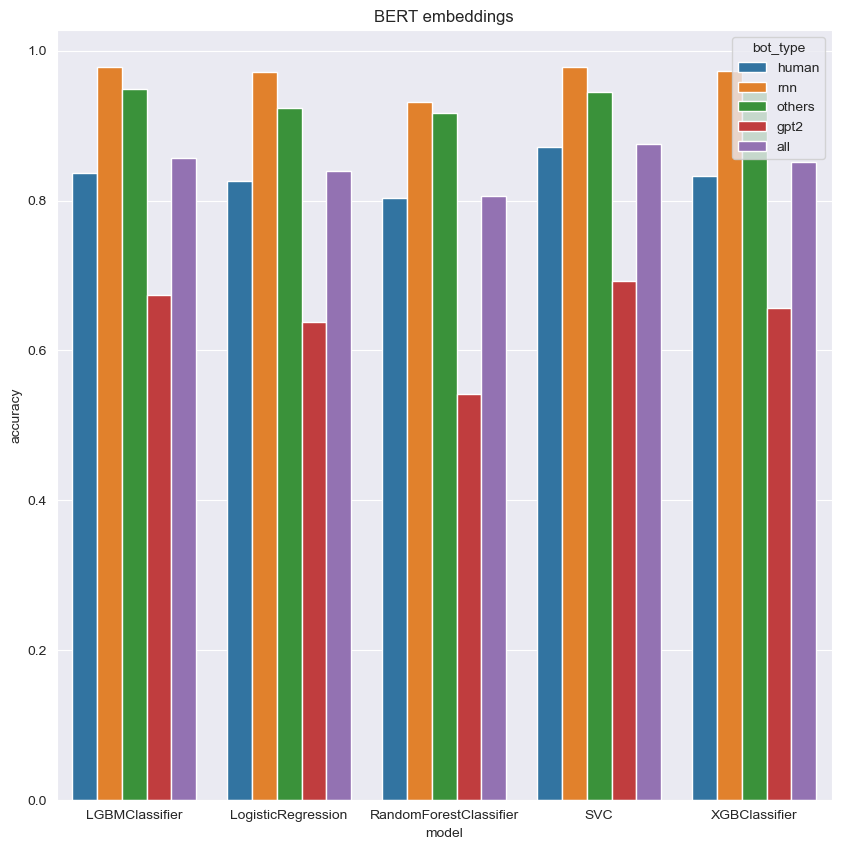

In [7]:
plt.figure(figsize=(10, 10))
sns.barplot(x="model", y="accuracy", hue="bot_type", data=bert_embeddings)
plt.title("BERT embeddings")
plt.show()

# TF-IDF
## Stemmed

In [8]:
models_path = os.path.join("..", "models", "tfidf", "stemmed")
data_path = os.path.join("..", "data", "stemmed")

In [9]:
test_data = pd.read_csv(os.path.join(data_path, "test.csv"))
x_test = test_data.text
y_test = np.where(test_data["account.type"] == "bot", 1, 0)
x_test.shape, y_test.shape

((2558,), (2558,))

In [10]:
def get_results_ml(models_path, x, y, test_data, type) -> pd.DataFrame:
    results = []
    bots_types = test_data["class_type"]
    for model_path in os.listdir(models_path):
        model = load_pickle(os.path.join(models_path, model_path))
        for bot_type in bots_types.unique():
            proper_index = test_data[test_data["class_type"] == bot_type].index
            x_type = x.loc[proper_index]
            y_type = y[proper_index]
            y_pred = model.predict(x_type)
            results.append(
                {
                    "accuracy": accuracy_score(y_type, y_pred),
                    "model": model["model"].__class__.__name__,
                    "bot_type": bot_type,
                    "type": type
                }
            )
        results.append(
            {
                "accuracy": accuracy_score(y, model.predict(x)),
                "model": model["model"].__class__.__name__,
                "bot_type": "all",
                "type": type
            }
        )
    return pd.DataFrame(results)

In [11]:
stemmed = get_results_ml(models_path, x_test, y_test, test_data, "tfidf stemmed")
stemmed

,accuracy,model,bot_type,type
0,0.715962,LGBMClassifier,human,tfidf stemmed
1,0.939320,LGBMClassifier,rnn,tfidf stemmed
2,0.995868,LGBMClassifier,others,tfidf stemmed
3,0.807292,LGBMClassifier,gpt2,tfidf stemmed
4,0.818608,LGBMClassifier,all,tfidf stemmed
5,0.767606,LogisticRegression,human,tfidf stemmed
6,0.944175,LogisticRegression,rnn,tfidf stemmed
7,0.942149,LogisticRegression,others,tfidf stemmed
8,0.736979,LogisticRegression,gpt2,tfidf stemmed
9,0.824472,LogisticRegression,all,tfidf stemmed


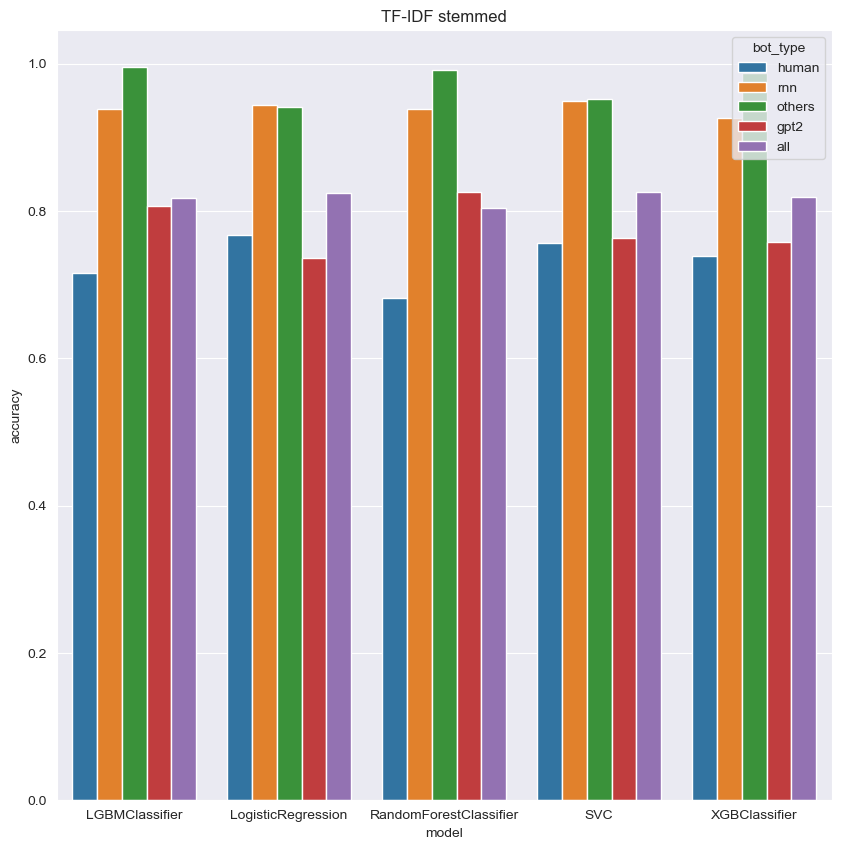

In [12]:
plt.figure(figsize=(10, 10))
sns.barplot(x="model", y="accuracy", hue="bot_type", data=stemmed)
plt.title("TF-IDF stemmed")
plt.show()

## Lemmatized

In [13]:
models_path = os.path.join("..", "models", "tfidf", "lemmatization")
data_path = os.path.join("..", "data", "lemmatized")

In [14]:
test_data = pd.read_csv(os.path.join(data_path, "test.csv"))
x_test = test_data.text
y_test = np.where(test_data["account.type"] == "bot", 1, 0)
x_test.shape, y_test.shape

((2558,), (2558,))

In [15]:
lemmatized = get_results_ml(models_path, x_test, y_test, test_data, "tfidf lemmatized")
lemmatized

,accuracy,model,bot_type,type
0,0.743349,LGBMClassifier,human,tfidf lemmatized
1,0.951456,LGBMClassifier,rnn,tfidf lemmatized
2,0.962810,LGBMClassifier,others,tfidf lemmatized
3,0.770833,LGBMClassifier,gpt2,tfidf lemmatized
4,0.822518,LGBMClassifier,all,tfidf lemmatized
5,0.766823,LogisticRegression,human,tfidf lemmatized
6,0.949029,LogisticRegression,rnn,tfidf lemmatized
7,0.917355,LogisticRegression,others,tfidf lemmatized
8,0.726562,LogisticRegression,gpt2,tfidf lemmatized
9,0.818608,LogisticRegression,all,tfidf lemmatized


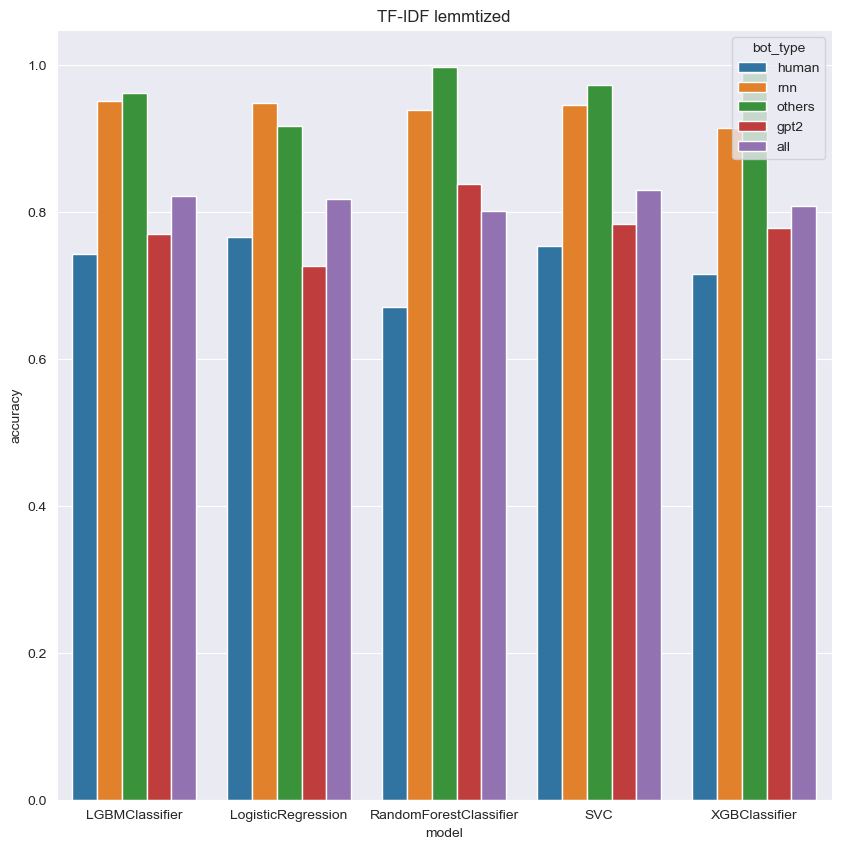

In [16]:
plt.figure(figsize=(10, 10))
sns.barplot(x="model", y="accuracy", hue="bot_type", data=lemmatized)
plt.title("TF-IDF lemmtized")
plt.show()

## Original

In [17]:
models_path = os.path.join("..", "models", "tfidf", "preprocessed")
data_path = os.path.join("..", "data", "preprocessed_url_simple")

In [18]:
test_data = pd.read_csv(os.path.join(data_path, "test.csv"))
x_test = test_data.text
y_test = np.where(test_data["account.type"] == "bot", 1, 0)
x_test.shape, y_test.shape

((2558,), (2558,))

In [19]:
preprocessed = get_results_ml(models_path, x_test, y_test, test_data, "tfidf preprocessed")
preprocessed

,accuracy,model,bot_type,type
0,0.720657,LGBMClassifier,human,tfidf preprocessed
1,0.951456,LGBMClassifier,rnn,tfidf preprocessed
2,0.993802,LGBMClassifier,others,tfidf preprocessed
3,0.815104,LGBMClassifier,gpt2,tfidf preprocessed
4,0.823690,LGBMClassifier,all,tfidf preprocessed
5,0.739437,LogisticRegression,human,tfidf preprocessed
6,0.936893,LogisticRegression,rnn,tfidf preprocessed
7,0.915289,LogisticRegression,others,tfidf preprocessed
8,0.723958,LogisticRegression,gpt2,tfidf preprocessed
9,0.802189,LogisticRegression,all,tfidf preprocessed


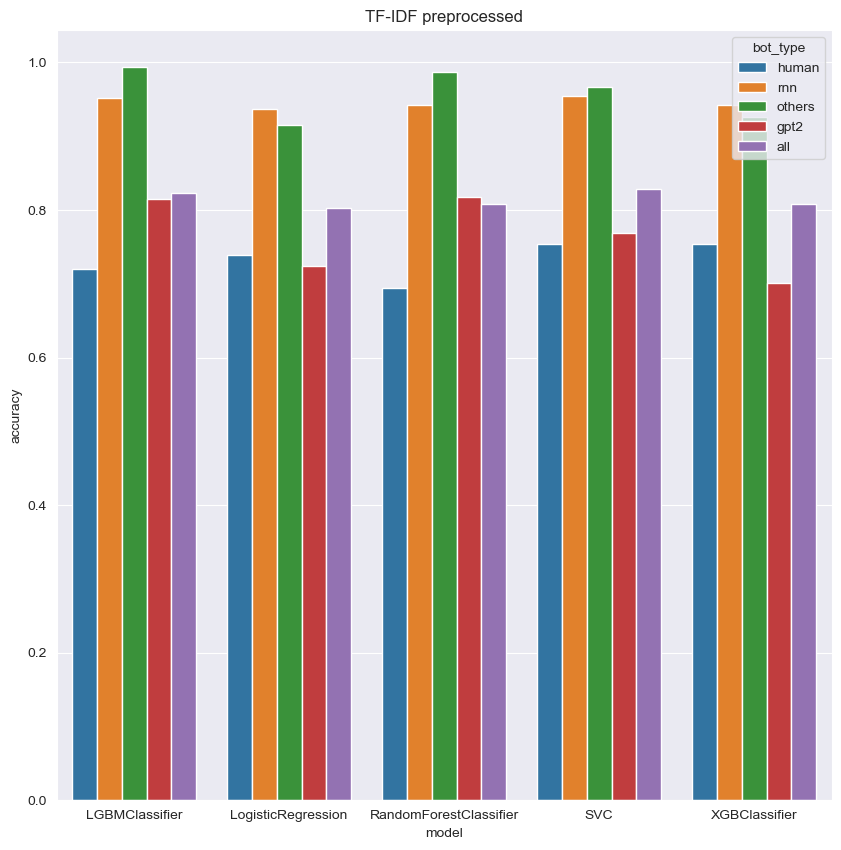

In [20]:
plt.figure(figsize=(10, 10))
sns.barplot(x="model", y="accuracy", hue="bot_type", data=preprocessed)
plt.title("TF-IDF preprocessed")
plt.show()

# Character-based Deep Learning
## CNN

In [21]:
from notebooks.utils.KerasModels import prepare_data

In [22]:
models_path = os.path.join("..", "models", "charCNN")

In [23]:
def get_results_dl(models_path, model_name) -> pd.DataFrame:
    results = []

    for model_path in os.listdir(models_path):
        model = load_model(os.path.join(models_path, model_path))
        data_path_char = os.path.join("..", "data", "preprocessed_url_simple" if model_path == "simple" else model_path)
        test_data_char = pd.read_csv(os.path.join(data_path_char, "test.csv"))
        _, _, test_features, _, _, test_labels, _ = prepare_data(data_path_char)
        bots_types = test_data_char["class_type"]
        for bot_type in bots_types.unique():
            proper_index = test_data_char[test_data["class_type"] == bot_type].index
            x_type = test_features[proper_index]
            y_type = [test_labels[i] for i in proper_index]
            y_pred = np.where(model.predict(x_type) > 0.5, 1, 0)
            results.append(
                {
                    "accuracy": accuracy_score(y_type, y_pred),
                    "model": model_name,
                    "bot_type": bot_type,
                    "type": model_path
                }
            )
        y_pred = np.where(model.predict(test_features) > 0.5, 1, 0)
        results.append(
            {
                "accuracy": accuracy_score(test_labels, y_pred),
                "model": model_name,
                "bot_type": "all",
                "type": model_path
            }
        )
    return pd.DataFrame(results)


charCNN = get_results_dl(models_path, "CharCNN")
charCNN

80/80 [==============================] - 0s 1ms/step


,accuracy,model,bot_type,type
0,0.796557,CharCNN,human,lemmatized
1,0.983010,CharCNN,rnn,lemmatized
2,0.933884,CharCNN,others,lemmatized
3,0.703125,CharCNN,gpt2,lemmatized
4,0.838546,CharCNN,all,lemmatized
5,0.806729,CharCNN,human,simple
6,0.983010,CharCNN,rnn,simple
7,0.896694,CharCNN,others,simple
8,0.713542,CharCNN,gpt2,simple
9,0.838155,CharCNN,all,simple


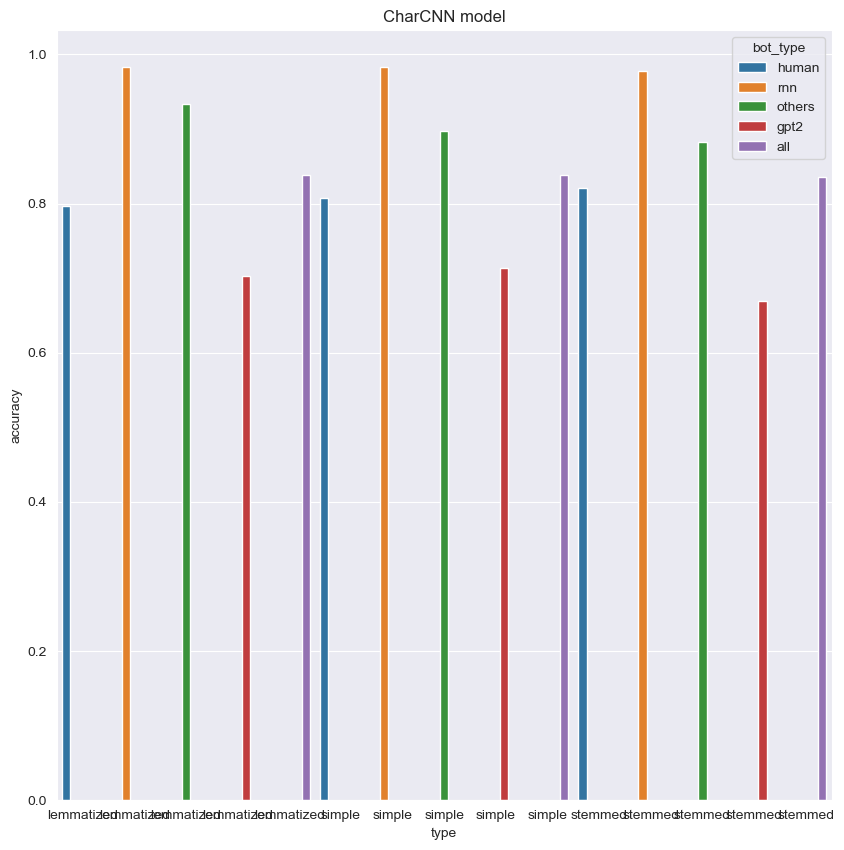

In [24]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=charCNN.index, y="accuracy", hue="bot_type", data=charCNN)
ax.set_xticklabels(charCNN["type"])
ax.set_xlabel("type")
plt.title("CharCNN model")
plt.show()

## GRU

In [25]:
models_path = os.path.join("..", "models", "charGRU")
charGRU = get_results_dl(models_path, "CharGRU")
charGRU

80/80 [==============================] - 1s 15ms/step


,accuracy,model,bot_type,type
0,0.713615,CharGRU,human,lemmatized
1,0.983010,CharGRU,rnn,lemmatized
2,0.979339,CharGRU,others,lemmatized
3,0.828125,CharGRU,gpt2,lemmatized
4,0.824472,CharGRU,all,lemmatized
5,0.794210,CharGRU,human,simple
6,0.980583,CharGRU,rnn,simple
7,0.919421,CharGRU,others,simple
8,0.710938,CharGRU,gpt2,simple
9,0.835418,CharGRU,all,simple


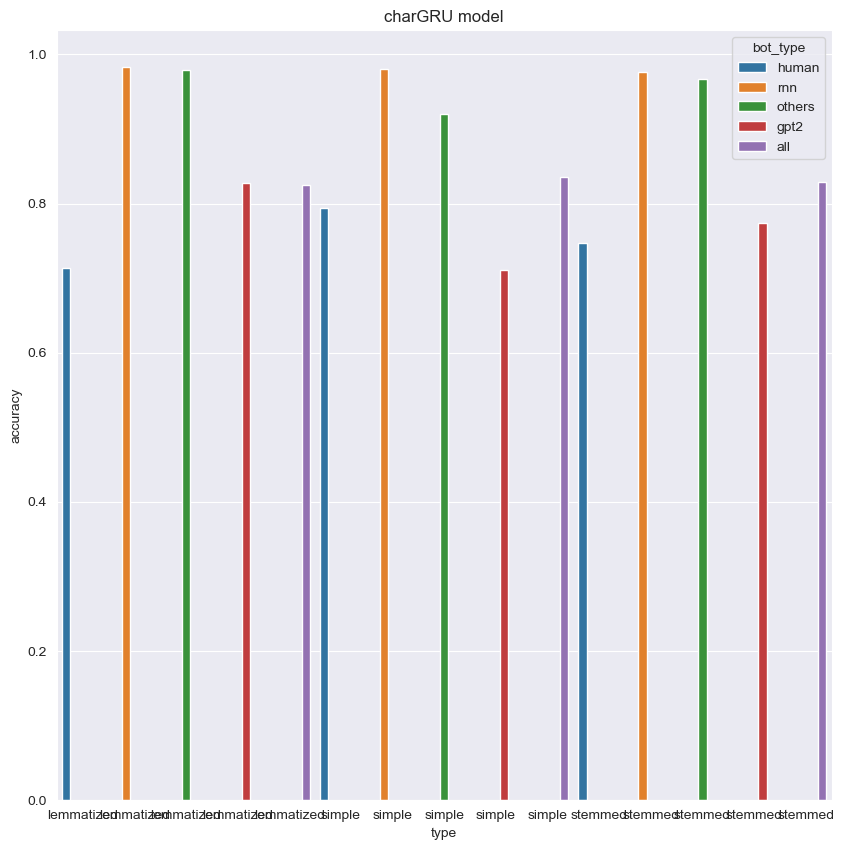

In [26]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=charGRU.index, y="accuracy", hue="bot_type", data=charGRU)
ax.set_xticklabels(charGRU["type"])
ax.set_xlabel("type")
plt.title("charGRU model")
plt.show()

## CNN + GRU

In [27]:
models_path = os.path.join("..", "models", "charCNN_GRU")
charCNN_GRU = get_results_dl(models_path, "CharCNN_GRU")
charCNN_GRU

80/80 [==============================] - 1s 15ms/step


,accuracy,model,bot_type,type
0,0.767606,CharCNN_GRU,human,lemmatized
1,0.985437,CharCNN_GRU,rnn,lemmatized
2,0.962810,CharCNN_GRU,others,lemmatized
3,0.776042,CharCNN_GRU,gpt2,lemmatized
4,0.840891,CharCNN_GRU,all,lemmatized
5,0.755086,CharCNN_GRU,human,simple
6,0.990291,CharCNN_GRU,rnn,simple
7,0.938017,CharCNN_GRU,others,simple
8,0.786458,CharCNN_GRU,gpt2,simple
9,0.832291,CharCNN_GRU,all,simple


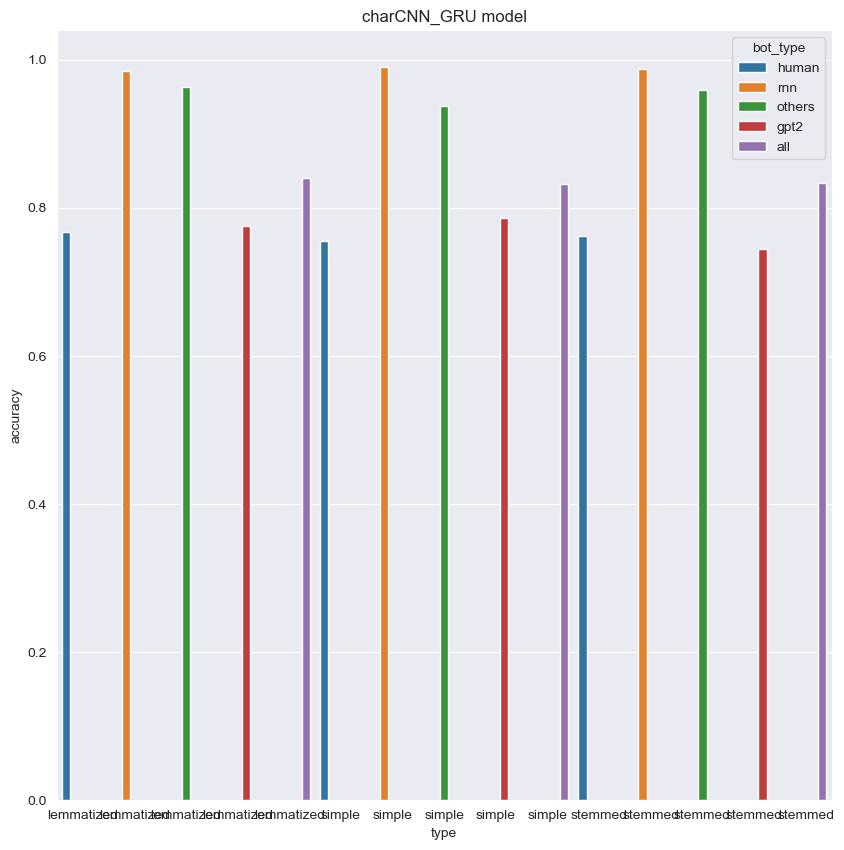

In [28]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=charCNN_GRU.index, y="accuracy", hue="bot_type", data=charCNN_GRU)
ax.set_xticklabels(charCNN_GRU["type"])
ax.set_xlabel("type")
plt.title("charCNN_GRU model")
plt.show()

# Word-based Deep Learning

## CNN

In [29]:
from notebooks.utils.word_utils import prepare_data

models_path = os.path.join("..", "models", "wordCNN")


def get_results_dl_word(models_path, model_name) -> pd.DataFrame:
    results = []

    for model_path in os.listdir(models_path):
        model = load_model(os.path.join(models_path, model_path))
        data_path_char = os.path.join("..", "data", "preprocessed_url_simple" if model_path == "simple" else model_path)
        test_data_char = pd.read_csv(os.path.join(data_path_char, "test.csv"))
        _, _, _, _, test_features, test_labels = prepare_data(data_path_char)
        bots_types = test_data_char["class_type"]
        for bot_type in bots_types.unique():
            proper_index = test_data_char[test_data["class_type"] == bot_type].index
            x_type = test_features[proper_index]
            y_type = [test_labels[i] for i in proper_index]
            y_pred = np.where(model.predict(x_type) > 0.5, 1, 0)
            results.append(
                {
                    "accuracy": accuracy_score(y_type, y_pred),
                    "model": model_name,
                    "bot_type": bot_type,
                    "type": model_path
                }
            )
        y_pred = np.where(model.predict(test_features) > 0.5, 1, 0)
        results.append(
            {
                "accuracy": accuracy_score(test_labels, y_pred),
                "model": model_name,
                "bot_type": "all",
                "type": model_path
            }
        )
    return pd.DataFrame(results)

In [30]:
wordCNN = get_results_dl_word(models_path, "WordCNN")
wordCNN

80/80 [==============================] - 0s 2ms/step


,accuracy,model,bot_type,type
0,0.792645,WordCNN,human,lemmatized
1,0.961165,WordCNN,rnn,lemmatized
2,0.838843,WordCNN,others,lemmatized
3,0.669271,WordCNN,gpt2,lemmatized
4,0.810008,WordCNN,all,lemmatized
5,0.787950,WordCNN,human,simple
6,0.953883,WordCNN,rnn,simple
7,0.867769,WordCNN,others,simple
8,0.713542,WordCNN,gpt2,simple
9,0.818608,WordCNN,all,simple


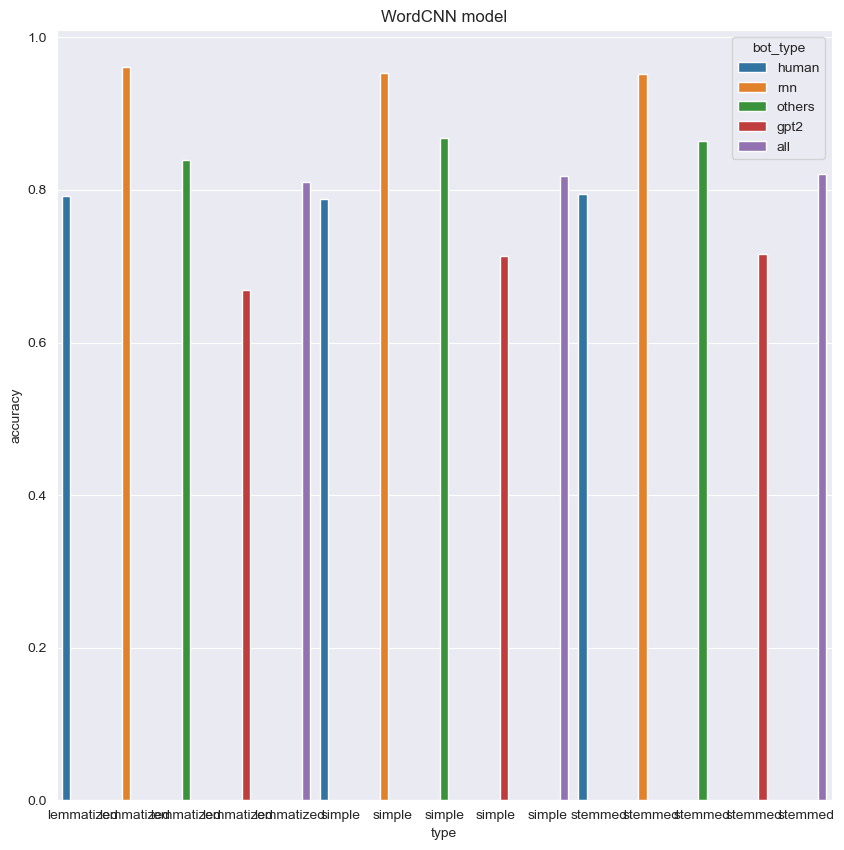

In [31]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=wordCNN.index, y="accuracy", hue="bot_type", data=wordCNN)
ax.set_xticklabels(wordCNN["type"])
ax.set_xlabel("type")
plt.title("WordCNN model")
plt.show()

## GRU

In [32]:
models_path = os.path.join("..", "models", "wordGRU")
wordGRU = get_results_dl_word(models_path, "WordGRU")
wordGRU

80/80 [==============================] - 0s 6ms/step


,accuracy,model,bot_type,type
0,0.776995,WordGRU,human,lemmatized
1,0.949029,WordGRU,rnn,lemmatized
2,0.927686,WordGRU,others,lemmatized
3,0.747396,WordGRU,gpt2,lemmatized
4,0.828772,WordGRU,all,lemmatized
5,0.818466,WordGRU,human,simple
6,0.944175,WordGRU,rnn,simple
7,0.793388,WordGRU,others,simple
8,0.622396,WordGRU,gpt2,simple
9,0.804535,WordGRU,all,simple


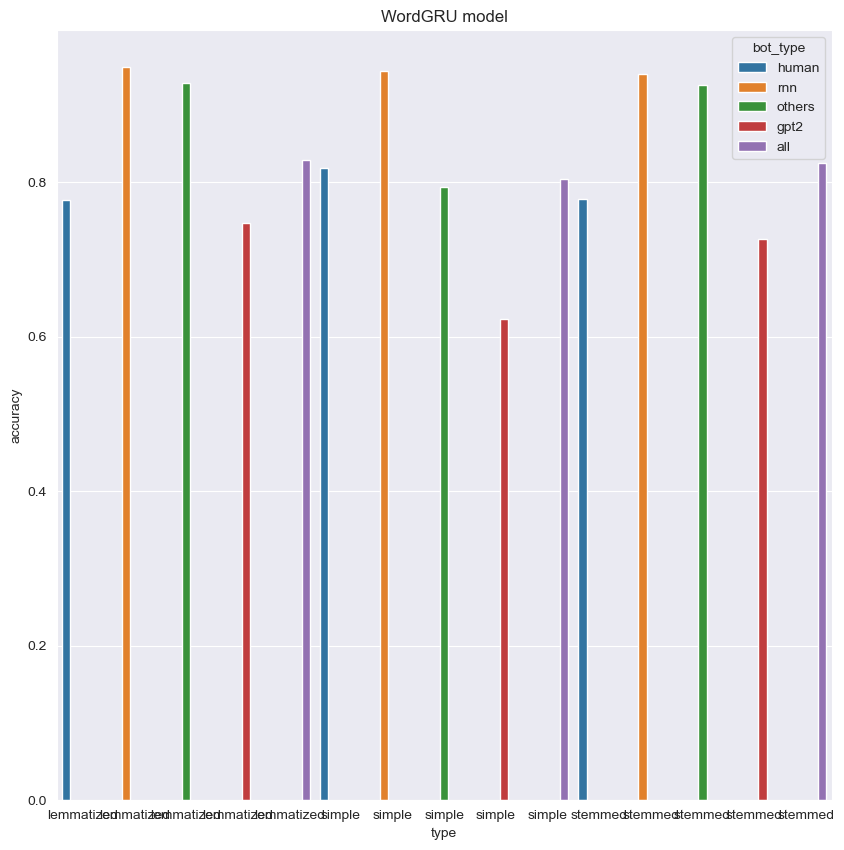

In [33]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=wordGRU.index, y="accuracy", hue="bot_type", data=wordGRU)
ax.set_xticklabels(wordGRU["type"])
ax.set_xlabel("type")
plt.title("WordGRU model")
plt.show()

## CNN + GRU

In [34]:
models_path = os.path.join("..", "models", "wordCNN_GRU")
wordCNN_GRU = get_results_dl_word(models_path, "WordCNN_GRU")
wordCNN_GRU

80/80 [==============================] - 1s 7ms/step


,accuracy,model,bot_type,type
0,0.789515,WordCNN_GRU,human,lemmatized
1,0.958738,WordCNN_GRU,rnn,lemmatized
2,0.871901,WordCNN_GRU,others,lemmatized
3,0.708333,WordCNN_GRU,gpt2,lemmatized
4,0.820172,WordCNN_GRU,all,lemmatized
5,0.780908,WordCNN_GRU,human,simple
6,0.958738,WordCNN_GRU,rnn,simple
7,0.882231,WordCNN_GRU,others,simple
8,0.708333,WordCNN_GRU,gpt2,simple
9,0.817826,WordCNN_GRU,all,simple


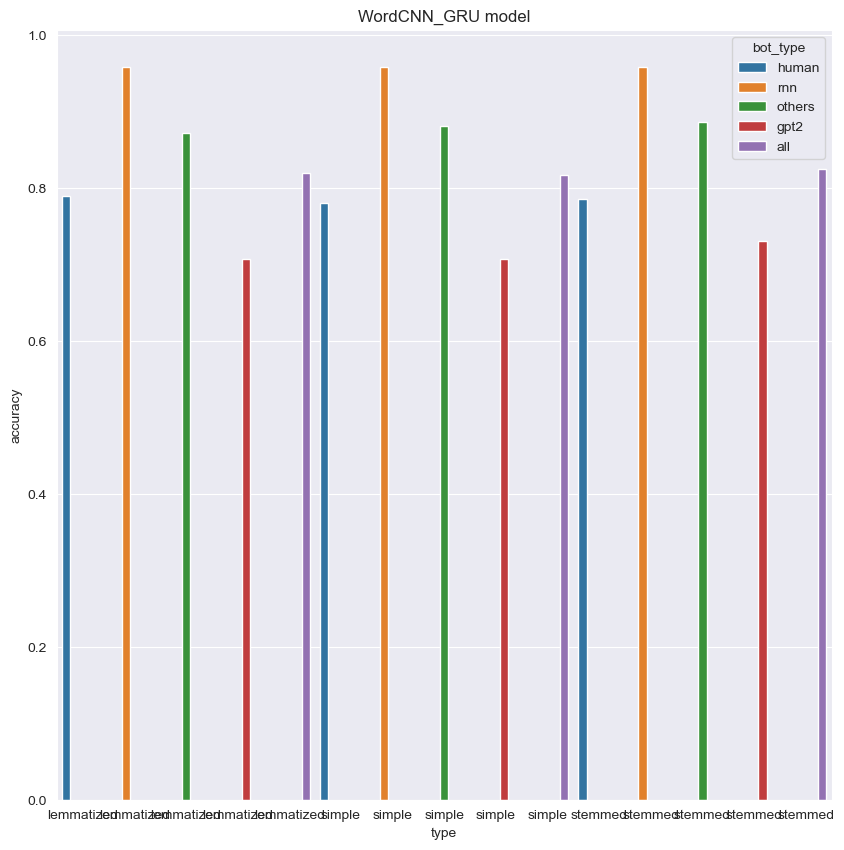

In [35]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=wordCNN_GRU.index, y="accuracy", hue="bot_type", data=wordCNN_GRU)
ax.set_xticklabels(wordCNN_GRU["type"])
ax.set_xlabel("type")
plt.title("WordCNN_GRU model")
plt.show()

# Results

In [36]:
results = pd.concat(
    [bert_embeddings, stemmed, lemmatized, preprocessed, charCNN, charGRU, charCNN_GRU, wordCNN, wordGRU, wordCNN_GRU])
results.to_csv(os.path.join("results", "results_in_depth.csv"))
results

,accuracy,model,bot_type,type
0,0.836463,LGBMClassifier,human,bert_embeddings
1,0.978155,LGBMClassifier,rnn,bert_embeddings
2,0.948347,LGBMClassifier,others,bert_embeddings
3,0.674479,LGBMClassifier,gpt2,bert_embeddings
4,0.856138,LGBMClassifier,all,bert_embeddings
...,...,...,...,...
10,0.786385,WordCNN_GRU,human,stemmed
11,0.958738,WordCNN_GRU,rnn,stemmed
12,0.886364,WordCNN_GRU,others,stemmed
13,0.731771,WordCNN_GRU,gpt2,stemmed
